# Classifying Rainier Wildflowers

This is an initial toy project, based off the material in chapter 1 of the FastAI course, where I try to build a classifier that
distinguishes between various kinds of rainier wildflowers.

The code as is requires separate downloads for each variety, so to keep it manageable i only chose a few varieties of wildflowers (though it would be interesting to try to loop over them to get all of them)


In [1]:
import time

from ddgs import DDGS #DuckDuckGo has changed the api so we need to update
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

/opt/anaconda3/envs/fast-ai/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


We start by downloading a few sample images

https://c8.alamy.com/comp/2YYM508/tundra-aster-oreostemma-alpigenum-2YYM508.jpg


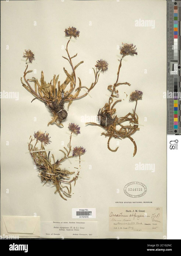

https://thumbs.dreamstime.com/z/vertical-shot-pacific-lupine-lupinus-lepidus-field-perfect-wallpapers-259820453.jpg


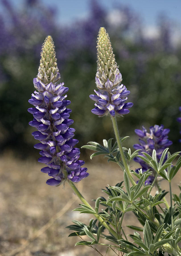

http://phytoimages.siu.edu/CUBIC_IMAGES/phytoimages/Cusman1/6_28_13/DSCF2331Polemoniumelegans.jpg


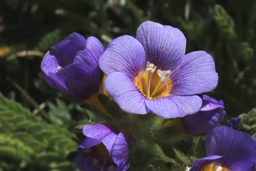

http://science.halleyhosting.com/nature/plants/sun/button/cirsium/edule/edule3a.jpg


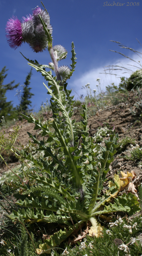

In [2]:
from fastdownload import download_url
from fastai.vision.all import *
# from IPython.display import Image, display

flower_types = [ 'oresostemma alpigenum', 'lupinus lepidus', 'polemonium elegans', 'cirsium edule']

def convert_to_filename(s):
    translator = str.maketrans('', '', string.punctuation)
    stripped_type = s.translate(translator)
    return ("_".join(stripped_type.split(' '))).lower()

for flower_type in flower_types:
    urls = search_images(flower_type, max_images=2)
    print(urls[1])
    underscored_type = convert_to_filename(flower_type)
    dest = "{}.jpg".format(underscored_type)
    download_url(urls[0], dest, show_progress=False)
    im = Image.open(dest)
    im = im.to_thumb(256, 256)
    display(im)

# urls = search_images('alpine aster', max_images=1)
# for url in urls:
#     print(url)
#
# dest = 'alpine_aster.jpg'
# download_url(urls[0], dest, show_progress=False)
#
# im = Image.open(dest)
# im.to_thumb(256,256)


Our searches look reasonable, so let's get some more.

In [7]:
base_dest_dir = Path('data')

for flower_type in flower_types:
    dirname = convert_to_filename(flower_type)
    print(dirname)
    dest_dir = (base_dest_dir/dirname)
    dest_dir.mkdir(exist_ok=True, parents=True)
    download_images(dest_dir, urls=search_images(flower_type))
    time.sleep(5)
    resize_images(base_dest_dir/dirname, max_size = 400, dest=dest_dir)



oresostemma_alpigenum
lupinus_lepidus
polemonium_elegans
cirsium_edule


Now let's train a model on this data.  First, we need to filter out anything that isn't a legit image.  Else the model will choke.

In [8]:
failed = verify_images(get_image_files(base_dest_dir))
failed.map(Path.unlink)
len(failed)

6

`DataLoaders` is the mechanism by which we pass our data to fastai's trainer to do our learning.

data


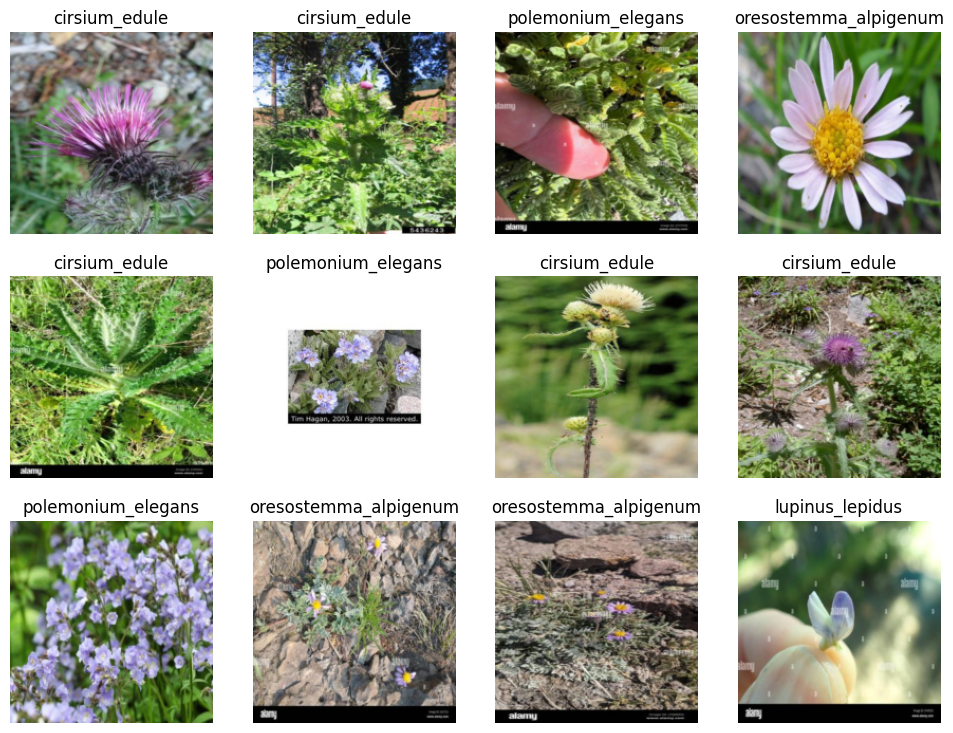

In [10]:

base_dest_dir = Path('data')
print(base_dest_dir)

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(base_dest_dir, bs=32)

dls.show_batch(max_n=12)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.131951,0.891073,0.346667,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.850275,0.662498,0.280000,00:01
1,0.612932,0.511112,0.146667,00:01
2,0.434592,0.511642,0.146667,00:01
3,0.318064,0.465224,0.146667,00:01
4,0.247583,0.461227,0.146667,00:01
